# Trabajo Final (Práctico IV) Diplomatura en Ciencia de datos, inteligencia Artificial y sus aplicaciones en Economía y negocios.

**Integrantes de Equipo: Sofía Donadio, Javier Flores, Paula E. Pérez y Florencia Villalba.**


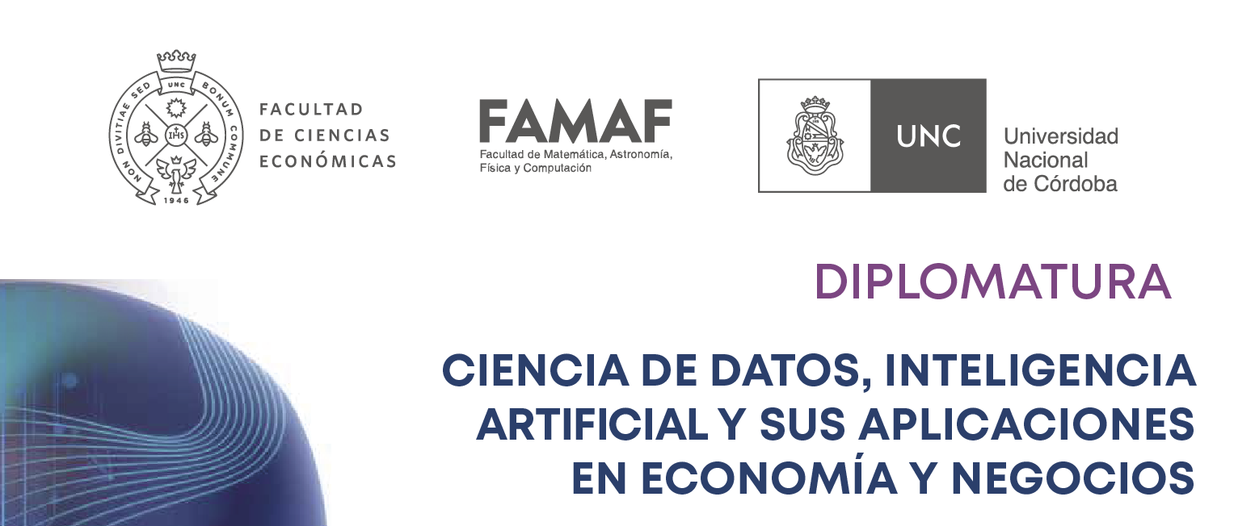

# I. Consigna.

En la presente notebook, se desarrollarán los enunciados solicitados para el trabajo final/Práctico IV de la *Diplomatura en Ciencia de Datos - 2021* 


De acuerdo a la consigna propuesta nuestro trabajo aquí, se centra en analizar los precios de locales comerciales de la Ciudad de Buenos Aires/CABA con el fin de predecir sus precios de venta a partir características propias de estos inmuebles (metros cuadrados, cantidad de ambientes, antiguedad, etc) como así también una serie de variables contextuales (relacionadas con su ubicación) construidas a partir de información georreferenciada (parques, atracciones turísticas, sitios gastronómicos, seguridad, etc).
Se pretende encontrar un modelo que encuentre el mejor precio de un inmueble comercial , dada una serie de características que hacen que el local, se diferencie respecto al resto. De esta manera, un emprendedor puede encontrar de manera óptima, el mejor local para desarrollar su proyecto.




# II. Environment/Entorno.

In [ ]:
#Importamos las librerias necesarias
import numpy as np
import pandas as pd
import seaborn as sns
#Herramientas gráficas
import matplotlib.pyplot as plt
import plotly.express as px   
!pip install plotly==5.3.1          
import plotly.graph_objects as go
import plotly.io as pio                                                         # https://plotly.com/python/templates/
pio.templates
from plotly.subplots import make_subplots
#Herramientas para graficar info georeferenciada
import json
from urllib.request import urlopen

## Filtramos advertencias relacionadas con la convergencia de los algoritmos
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

## Clases y funciones útiles de scikit-learn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

## Modelo neuronal:
## Multi-Layer Perceptron
from sklearn.neural_network import MLPRegressor

## Otros modelos para comparar con el modelo neuronal
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


# III. Base de datos. Importación

In [ ]:
#Tomamos el archivo desde el Drive
data = pd.read_csv('https://drive.google.com/uc?export=download&id=1aNVwQCbazAhJGh2aC-ThUnWZLm74vLLp')

#III. Base de datos. Limpieza y  preparación

In [ ]:
#Vemos las primeras 5 lineas del DataFrame
data.head()

,id,antig,m2total,m2cub,ambientes,banios,direccion,barrio,comuna,latitud,longitud,precioUSD,m2precioUSD,comisaria_dista,obelisco_dista,nrobos,sup_espacio_verde,count_gastronomia,count_culturales
0,1,0,200,200,0,0,Gral Paz y Rivadavia,LINIERS,9,-34.639300,-58.528647,1500000,7500.000000,1162.621600,14053.797191,134,68426.445,12,0
1,2,30,50,50,0,1,Asuncion,VILLA DEVOTO,11,-34.611807,-58.528138,125000,2500.000000,1887.227055,13473.139375,23,110997.543,3,0
2,3,30,414,414,0,2,Avenida Beiro 5574,VILLA REAL,10,-34.616468,-58.528111,590000,1425.120773,1497.020434,13514.662463,33,115341.039,5,0
3,4,35,414,414,0,2,Avenida Beiro 5574,VILLA REAL,10,-34.616344,-58.527918,730000,1763.000000,1506.066814,13495.631683,33,115500.289,5,0
4,5,35,285,285,0,1,Avenida Beiro 5574,VILLA REAL,10,-34.616344,-58.527918,550000,1929.000000,1506.066814,13495.631683,33,115500.289,5,0


In [ ]:
# Dimensiones de la base original
data.shape

(3711, 19)

Poseemos 3711 inmuebles, y 19 "variables" para cada uno.

In [ ]:
#Información del dataset
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3711 entries, 0 to 3710
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 3711 non-null   int64  
 1   antig              3711 non-null   int64  
 2   m2total            3711 non-null   int64  
 3   m2cub              3711 non-null   int64  
 4   ambientes          3711 non-null   int64  
 5   banios             3711 non-null   int64  
 6   direccion          3707 non-null   object 
 7   barrio             3711 non-null   object 
 8   comuna             3711 non-null   int64  
 9   latitud            3711 non-null   float64
 10  longitud           3711 non-null   float64
 11  precioUSD          3711 non-null   int64  
 12  m2precioUSD        3711 non-null   float64
 13  comisaria_dista    3711 non-null   float64
 14  obelisco_dista     3711 non-null   float64
 15  nrobos             3711 non-null   int64  
 16  sup_espacio_verde  3711 

Vemos que no existen datos faltantes en las columnas, tambien vemos que la mayoria son de tipo numerico, ya sean int o float. Solo dos columnas son de tipo object, es decir que se trata de variables categoricas (Dirección y barrio)

In [ ]:
#Obtenemos algunas medidas estadisticas generales de nuestro Dataset
data.describe() 

,id,antig,m2total,m2cub,ambientes,banios,comuna,latitud,longitud,precioUSD,m2precioUSD,comisaria_dista,obelisco_dista,nrobos,sup_espacio_verde,count_gastronomia,count_culturales
count,3711.000000,3711.000000,3711.000000,3711.000000,3711.000000,3711.000000,3711.000000,3711.000000,3711.000000,3.711000e+03,3711.000000,3711.000000,3711.000000,3711.000000,3711.000000,3711.000000,3711.000000
mean,1856.000000,14.045810,170.163029,157.668014,0.392886,1.138777,7.282134,-34.602917,-58.424922,4.199982e+05,3041.276822,687.923745,4787.447523,135.369712,80565.178971,40.021827,9.488278
std,1071.417752,21.731839,305.479189,305.640985,1.399959,1.298509,5.449637,0.022221,0.039282,6.216290e+05,2021.176619,372.091329,3457.615713,72.990312,81479.893509,47.551593,12.578286
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-34.694053,-58.528647,1.500000e+04,204.000000,19.198073,1.605225,2.000000,276.336000,0.000000,0.000000
25%,928.500000,0.000000,46.000000,40.000000,0.000000,0.000000,2.000000,-34.615422,-58.453078,1.300000e+05,1750.000000,422.736477,1878.550379,77.000000,26370.141500,8.000000,1.000000
50%,1856.000000,0.000000,100.000000,90.000000,0.000000,1.000000,6.000000,-34.601862,-58.421367,2.600000e+05,2500.000000,632.887670,4143.061854,131.000000,55826.199000,19.000000,5.000000
75%,2783.500000,30.000000,204.000000,190.000000,0.000000,2.000000,13.000000,-34.591262,-58.389804,4.900000e+05,3703.000000,922.017363,7218.496630,179.000000,117023.245000,62.000000,14.000000
max,3711.000000,102.000000,14400.000000,14400.000000,22.000000,30.000000,15.000000,-34.537166,-58.356972,1.600000e+07,25200.000000,2276.831339,14160.617746,442.000000,811740.562000,251.000000,92.000000


De la descripción del dataset podemos ver a priori que en la variable metros cuadrados el valor máximo es 14400, esto podría tratarse de un error de información, también el mínimo es cero, podemos deducir que no se cargó información en esos casos. En la cantidad de ambientes el máximo es 22, podemos ver si tiene lógica con los metros cuadrados del local. En cuanto a la cantidad de baños, el maximo es 30, esto podría tratarse de algun error en la carga de información, y el minimo es cero, esto no llama la atención ya que puede haber locales comerciales sin baño, en un shopping por ejemplo. En cuanto a la variable "ambientes" parece tener muchos valores iguales a cero.

In [ ]:
#Informacion sobre la variable objetivo
pd.set_option('float_format', '{:f}'.format)
data['precioUSD'].describe() 

count       3711.000000
mean      419998.160334
std       621629.045229
min        15000.000000
25%       130000.000000
50%       260000.000000
75%       490000.000000
max     16000000.000000
Name: precioUSD, dtype: float64


Apreciamos que el 75% de los inmuebles se encuentra con un precio cercano al valor del precio promedio

▶▶▶ **Análisis de valores nulos y missings**

In [ ]:
#Contamos cuantos valores iguales a cero tiene la variable ambientes.
pd.value_counts(data['ambientes']==0)

True     3081
False     630
Name: ambientes, dtype: int64

Tiene 3081 valores cero lo cual representa un 83% de los inmuebles, por lo tanto consideramos que no aporta información importante al analisis, y procederemos a eliminarla. Tambien eliminaremos la columna "id"

In [ ]:
#Eliminaremos columnas que a simple vista no son útiles para el análisis
data = data.drop(['id','ambientes' ], axis=1)

In [ ]:
#Obtenemos algunas medidas estadisticas generales de nuestro Dataset
data.describe() 


,antig,m2total,m2cub,banios,comuna,latitud,longitud,precioUSD,m2precioUSD,comisaria_dista,obelisco_dista,nrobos,sup_espacio_verde,count_gastronomia,count_culturales
count,3711.000000,3711.000000,3711.000000,3711.000000,3711.000000,3711.000000,3711.000000,3711.000000,3711.000000,3711.000000,3711.000000,3711.000000,3711.000000,3711.000000,3711.000000
mean,14.045810,170.163029,157.668014,1.138777,7.282134,-34.602917,-58.424922,419998.160334,3041.276822,687.923745,4787.447523,135.369712,80565.178971,40.021827,9.488278
std,21.731839,305.479189,305.640985,1.298509,5.449637,0.022221,0.039282,621629.045229,2021.176619,372.091329,3457.615713,72.990312,81479.893509,47.551593,12.578286
min,0.000000,0.000000,0.000000,0.000000,1.000000,-34.694053,-58.528647,15000.000000,204.000000,19.198073,1.605225,2.000000,276.336000,0.000000,0.000000
25%,0.000000,46.000000,40.000000,0.000000,2.000000,-34.615422,-58.453078,130000.000000,1750.000000,422.736477,1878.550379,77.000000,26370.141500,8.000000,1.000000
50%,0.000000,100.000000,90.000000,1.000000,6.000000,-34.601862,-58.421367,260000.000000,2500.000000,632.887670,4143.061854,131.000000,55826.199000,19.000000,5.000000
75%,30.000000,204.000000,190.000000,2.000000,13.000000,-34.591262,-58.389804,490000.000000,3703.000000,922.017363,7218.496630,179.000000,117023.245000,62.000000,14.000000
max,102.000000,14400.000000,14400.000000,30.000000,15.000000,-34.537166,-58.356972,16000000.000000,25200.000000,2276.831339,14160.617746,442.000000,811740.562000,251.000000,92.000000


Observamos que hay propiedades que no poseen m2total ni banios, a su vez hay valores atipicos. Procedemos a indagar las variables.

In [ ]:
data.isnull().sum()                                                      #Intento verificar la existencia de valores nulos

antig                0
m2total              0
m2cub                0
banios               0
direccion            4
barrio               0
comuna               0
latitud              0
longitud             0
precioUSD            0
m2precioUSD          0
comisaria_dista      0
obelisco_dista       0
nrobos               0
sup_espacio_verde    0
count_gastronomia    0
count_culturales     0
dtype: int64

Al verificar la existencia de valores nulos, los cuales son pocos, se evidencia que se utilizó como criterio poner 0's donde no había datos, esto se explica al ver muchos inmuebles con "0" ambientes.

**Tomamos la decisión de eliminar valores atítipicos y concentrarnos en el cuartil que alberga información más útil.**

In [ ]:
#Identificamos cuales son los valores extremos de la variable precio 
Q1=data.precioUSD.quantile(q=0.25)
Q3=data.precioUSD.quantile(q=0.75)
LSE=Q3+3*(Q3-Q1)
LIE=Q1-3*(Q3-Q1)
print(LSE,Q1,Q3)

1570000.0 130000.0 490000.0


In [ ]:
#Vemos cuantos valores hay por encima del limite superior. 
pd.value_counts(data['precioUSD']< LSE.sum()).sort_index()

False     126
True     3585
Name: precioUSD, dtype: int64

In [ ]:
#Dejamos fuera del DataFrame los valores extremos.
data_grafico5 = data[data['precioUSD']< LSE]
print(data_grafico5.shape)

(3585, 17)


In [ ]:
#Identificamos cuales son los valores extremos de la variable metros cuadrados totales.
Q1=data_grafico5.m2total.quantile(q=0.25)
Q3=data_grafico5.m2total.quantile(q=0.75)
LSE=Q3+3*(Q3-Q1)
LIE=Q1-3*(Q3-Q1)
print(LSE,Q1,Q3)

637.0 45.0 193.0


In [ ]:
#Vemos cuantos valores hay por encima del limite superior. 
pd.value_counts(data_grafico5['m2total']< LSE.sum()).sort_index()

False      71
True     3514
Name: m2total, dtype: int64

In [ ]:
#Dejamos fuera del DataFrame los valores extremos.
data_grafico4 = data_grafico5[data_grafico5['m2total']< LSE]
print(data_grafico4.shape)

(3514, 17)


In [ ]:
#Identificamos cuales son los valores extremos de la variable baños.
Q1=data_grafico4.banios.quantile(q=0.25)
Q3=data_grafico4.banios.quantile(q=0.75)
LSE=Q3+3*(Q3-Q1)
LIE=Q1-3*(Q3-Q1)
print(LSE,Q1,Q3)

8.0 0.0 2.0


In [ ]:
#Vemos cuantos valores hay por encima del limite superior. 
pd.value_counts(data_grafico4['banios']< LSE.sum()).sort_index()

False       8
True     3506
Name: banios, dtype: int64

In [ ]:
#Dejamos fuera del DataFrame los valores extremos.
data_grafico3 = data_grafico4[data_grafico4['banios']< LSE]
print(data_grafico3.shape)

(3506, 17)


In [ ]:
#Eliminamos ceros en la variable m2total
data_grafico2 = data_grafico3.drop(data_grafico3[data_grafico3["m2total"]==0].index)
print(data_grafico2.shape)

(3454, 17)


In [ ]:
#Eliminamos los valores NaN del Data Frame
data_grafico = data_grafico2.dropna()
print(data_grafico.shape)

(3450, 17)


Despues de la limpieza, la base de datos nos quedo con un total de 3450 filas, comparadas con las 3711 iniciales, se dejan fuera de analisis 261 filas.

▶▶▶
 **Creación de Nuevas variables:**

In [ ]:
#Creamos una nueva variable precio expresada en miles, para su mejor interpretacion ya que por defecto nos devolvia valores en notacion cientifica.
data_grafico["precioUSDmiles"] = data_grafico["precioUSD"]/1000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#Expresamos las distancias en la misma unidad de medida (Km)
data['comisaria_distaKM'] = data['comisaria_dista'] / 1000
data['obelisco_distaKM'] = data['obelisco_dista'] / 1000
data['nroboskm'] = data['nrobos'] * 2


data_grafico['comisaria_distaKM'] = data_grafico['comisaria_dista'] / 1000
data_grafico['obelisco_distaKM'] = data_grafico['obelisco_dista'] / 1000
data_grafico['nroboskm'] = data_grafico['nrobos'] * 2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

Al encontrarse las variables a utilizar en diferente unidad de medida (metros y km), resulta necesario homogeneizarlas para la posterior creación de variables relativas.

**¿Cuántos robos hay respecto a la distancia a la comisaría más cercana?**

In [ ]:
data_grafico['nrobos_distanciacomisariakm'] = data_grafico['nrobos'] / data_grafico['comisaria_distaKM']
data['nrobos_distanciacomisariakm'] = data['nrobos'] / data['comisaria_distaKM']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


**¿Cuántos robos hay respecto a la distancia del Obelisco?**

In [ ]:
data_grafico['nrobos_distanciaobeliscokm'] = data_grafico['nrobos'] / data_grafico['obelisco_distaKM']
data['nrobos_distanciaobeliscokm'] = data['nrobos'] / data['obelisco_distaKM']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


**¿Qué condición tienen los inmuebles?**

In [ ]:
#Crearemos una nueva columna teniendo en cuenta la antiguedad de los locales comerciales, a fines de comparar los precios entre los locales a "Estrenar" y los "Usados".
def f(row):
    if row['antig'] == 0:
        val = 'A estrenar'
    elif row['antig'] != 0:
        val = 'Usado' 
    return val

In [ ]:
data_grafico['antig_'] = data_grafico.apply(f, axis=1)
data['antig_'] = data.apply(f, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
data_grafico.head()


,antig,m2total,m2cub,banios,direccion,barrio,comuna,latitud,longitud,precioUSD,m2precioUSD,comisaria_dista,obelisco_dista,nrobos,sup_espacio_verde,count_gastronomia,count_culturales,precioUSDmiles,comisaria_distaKM,obelisco_distaKM,nroboskm,nrobos_distanciacomisariakm,nrobos_distanciaobeliscokm,antig_
0,0,200,200,0,Gral Paz y Rivadavia,LINIERS,9,-34.639300,-58.528647,1500000,7500.000000,1162.621600,14053.797191,134,68426.445000,12,0,1500.000000,1.162622,14.053797,268,115.256761,9.534790,A estrenar
1,30,50,50,1,Asuncion,VILLA DEVOTO,11,-34.611807,-58.528138,125000,2500.000000,1887.227055,13473.139375,23,110997.543000,3,0,125.000000,1.887227,13.473139,46,12.187193,1.707100,Usado
2,30,414,414,2,Avenida Beiro 5574,VILLA REAL,10,-34.616468,-58.528111,590000,1425.120773,1497.020434,13514.662463,33,115341.039000,5,0,590.000000,1.497020,13.514662,66,22.043787,2.441792,Usado
3,35,414,414,2,Avenida Beiro 5574,VILLA REAL,10,-34.616344,-58.527918,730000,1763.000000,1506.066814,13495.631683,33,115500.289000,5,0,730.000000,1.506067,13.495632,66,21.911378,2.445236,Usado
4,35,285,285,1,Avenida Beiro 5574,VILLA REAL,10,-34.616344,-58.527918,550000,1929.000000,1506.066814,13495.631683,33,115500.289000,5,0,550.000000,1.506067,13.495632,66,21.911378,2.445236,Usado


Pensamos que puede resultar de mayor utilidad pensar en la cantidad de robos, de acuerdo a la distancia de las comisarias y del obelisco, en kilómetros.

**Agrego Dummys para diferenciar mejor las comunas**

In [ ]:
data_dummies_gr = pd.get_dummies(data_grafico["comuna"])
pd.concat([data_grafico, data_dummies_gr], axis = 1)
data_grafico.rename(columns={'1': 'Comuna 1', '2': 'Comuna 2', '3': 'Comuna 3', '4': 'Comuna 4', '5': 'Comuna 5', '6': 'Comuna 6', '7': 'Comuna 7', '8': 'Comuna 8', '9': 'Comuna 9', '10': 'Comuna 10', '11': 'Comuna 11', '12': 'Comuna 12', '13': 'Comuna 13', '14': 'Comuna 14', '15': 'Comuna 15'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
data_dummies_gr.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


#IV. Análisis EDA


#IV. Análisis EDA. UNIVARIADO

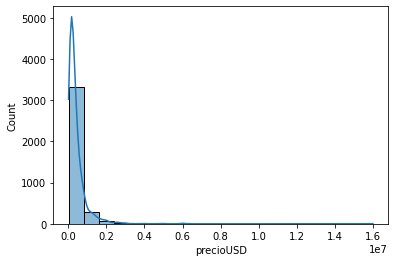

In [ ]:
#Hacemos un histograma de la variable objetivo
sns.histplot(data['precioUSD'], bins=20, kde=True)

Al tener valores extremos el grafico no se visualiza correctamente, vamos a crear un dataframe sin los valores extremos para poder visualizarlo mejor.

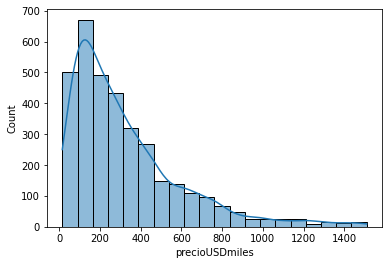

In [ ]:
sns.histplot(data_grafico['precioUSDmiles'], bins=20, kde=True)

Del histograma de la variable objetivo: precioUSD podemos ver que los datos tienen una distribución sesgada a derecha. La mayor cantidad de locales comerciales se encuentra hasta los 200.000 dolares aproximadamente, y hay menor cantidad de locales con precios superiores.

▶▶▶ **Análisis Exploración analizando información georeferenciada**

In [ ]:
#Creamos un mapa para visualizar variables georefenciadas
token = 'pk.eyJ1IjoicGF1bGFwZXJlemxlZ2lzIiwiYSI6ImNrd2M4b3VsMTI3bzEzMm84a3hsOWd4dnUifQ._DxTIilkq3ugwLMn-fUGug'
    
fig = go.Figure(go.Densitymapbox(
    
    lon=data.longitud,                                                          # Traemos la info geográfica desde el DF #alternativa https://plotly.com/python/mapbox-density-heatmaps/
    lat=data.latitud,
    #fill = None,                                                               #Fill rellena las lineas #TOSELF
    #mode = "marker",                                                     #Markers+lines o #markers+text o #marker solo
    z=data.precioUSD,                                                           #Magnitud
    radius=40,                                                                  #radio default 30                     
   
  hoverinfo= 'all',                                                             #Etiqueta de los colores, default 'ALL' se puede combinar variables usando el + 
  reversescale=True                                                             #Invertir escala TRUE o FALSE         
  #hovertext=                                                                  # Texto que sale sobre cada círculo cuando se pasa el cursor
  #'<b>Nombre Barrio</b>: ' + df['comuna'].astype(str) + '<br>' +
  #'<b>Precio</b>: ' + df['precioUSD'].astype(str) + '<br>' 
))

fig.update_layout(
    hovermode= 'x',
    #paper_bgcolor='#010915',
    margin=dict(r=0, l =0, b = 0, t = 0),
    mapbox=dict(
        accesstoken= token,
        style= 'dark',
        zoom=13,
        #marker=-34.60350486134861,-58.38159185989842
        center=dict(
            lat = -34.60350486134861, 
            lon = -58.38159185989842
        )
    ),
    showlegend = True,
    autosize=True
)

Gráficamente, se denota que los precios más altos, se encuentran alrededor del Obelisco, en cercanías al centro financiero de Buenos Aires. Y también en Puerto Madero y Villa Crespo. Lo cual resulta lógico, ya que el centro financiero tiene mucho tráfico de personas locales diariamente, Puerto madero es un área exclusiva y Villa Crespo tiene mucha presencia turística, por lo que no es ajeno pensar en que un local comercial, tenga un precio más elevado.

In [ ]:
#Creamos un mapa para visualizar variables georefenciadas
token = 'pk.eyJ1IjoicGF1bGFwZXJlemxlZ2lzIiwiYSI6ImNrd2M4b3VsMTI3bzEzMm84a3hsOWd4dnUifQ._DxTIilkq3ugwLMn-fUGug'
    
fig = go.Figure(go.Densitymapbox(
    
    lon=data.longitud,                                                          # Traemos la info geográfica desde el DF #alternativa https://plotly.com/python/mapbox-density-heatmaps/
    lat=data.latitud,
    #fill = None,                                                               #Fill rellena las lineas #TOSELF
    #mode = "markers+lines",                                                     #Markers+lines o #markers+text o #marker solo
    z=data_grafico.nroboskm,                                                           #Magnitud
    radius=20,                                                                  #radio default 30                     
   
  hoverinfo= 'all',                                                             #Etiqueta de los colores, default 'ALL' se puede combinar variables usando el + 
  reversescale=False                                                             #Invertir escala TRUE o FALSE         
  #hovertext=                                                                  # Texto que sale sobre cada círculo cuando se pasa el cursor
  #'<b>Nombre Barrio</b>: ' + df['comuna'].astype(str) + '<br>' +
  #'<b>Precio</b>: ' + df['precioUSD'].astype(str) + '<br>' 
))

fig.update_layout(
    hovermode= 'x',
    #paper_bgcolor='#010915',
    margin=dict(r=0, l =0, b = 0, t = 0),
    mapbox=dict(
        accesstoken= token,
        style= 'dark',
        zoom=13,
        center=dict(
            lat = -34.60350486134861, 
            lon = -58.38159185989842
        )
    ),
    showlegend = True,
    autosize=True
)

De acuerdo a la cantidad de robos, por km, el centro financiero de CABA parece tener mayor cantidad que otros barrios, esto quizás puede explicarse por el tráfico de personas por la zona, lo que resulta difícil de incorporar por el momento en el análisis, entonces no será contemplado en esta oportunidad. 

#IV. Análisis EDA. MULTIVARIADO

In [ ]:
#Definimos las variables que vamos a graficar en boxplot
data_boxplot = data[['antig','m2total', 'm2cub', 'banios','precioUSD','m2precioUSD','comisaria_dista','obelisco_dista','nrobos','sup_espacio_verde','count_gastronomia','count_culturales']]

In [ ]:
#Boxplots para cada una de las variables del dataframe que definimos
fig = make_subplots (4,3, subplot_titles=(data_boxplot.columns))

for i in range(12):
   variable = data_boxplot.columns[i]
   fig.add_trace(
   go.Box(y=data_boxplot[variable],  name=variable, orientation='v', showlegend=False),
   row= i//3+1, col= i%3+1
   )
  
fig.update_layout(height=1500, width=1200,title_text="Boxplots para cada variable")
fig.show()

De los boxplots para cada una de las variables confirmamos que existen muchos valores extremos en las variables nombradas anteriormente (metros cuadrados totales, baños, precio)

In [ ]:
fig = px.scatter(
    data_grafico, x='m2cub', y='precioUSDmiles', opacity=0.65,
    trendline='ols', trendline_color_override='red',
    marginal_x='box',
    marginal_y='violin', 
    hover_data=['antig', 'comuna'],
    title = 'Relación entre el precio de venta y la superficie  cubierta de las propiedades'
)
fig.update_traces(marker_size=10, marker_color= 'rgba(255, 182, 193, .9)')
fig.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
fig = px.scatter(
    data_grafico, x='m2total', y='precioUSDmiles', opacity=0.65,
    trendline='ols', trendline_color_override='red',
    marginal_x='box',
    marginal_y='violin', 
    hover_data=['antig', 'comuna'],
    title = 'Relación entre el precio de venta y la superficie de las propiedades'
)
fig.update_traces(marker_size=10, marker_color= 'rgba(255, 182, 193, .9)')
fig.show()

**Selección de variables a utilizar. Creación Data Frame**


In [ ]:
#Definimos el nuevo dataframe sin los valores extremos y con inmuebles menores a 500 m2
data_500= data_grafico[data['m2total']< 500]
print(data_500.shape)

(3351, 24)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



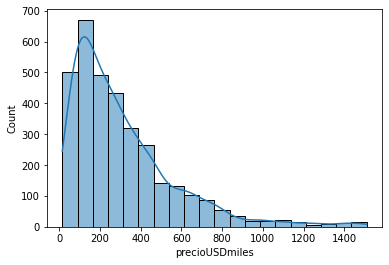

In [ ]:
sns.histplot(data_500['precioUSDmiles'], bins=20, kde=True)

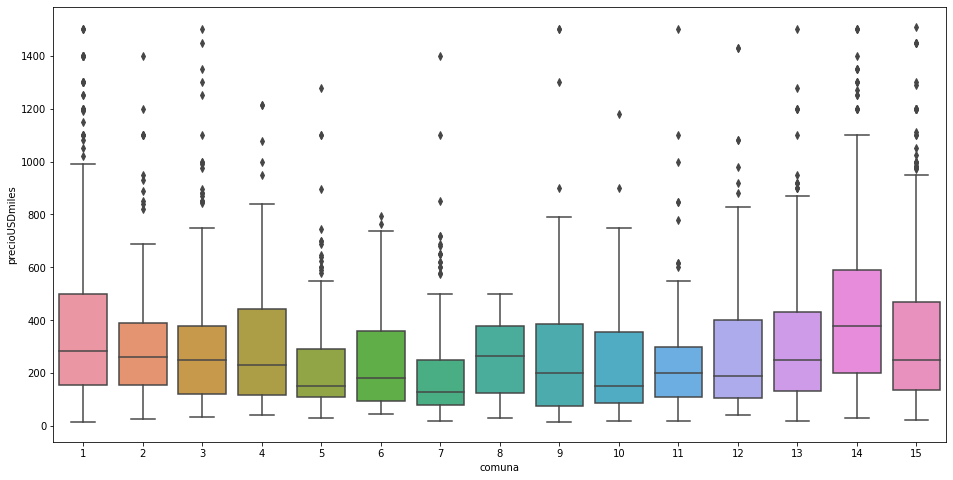

In [ ]:
#Analizamos el precio de los locales comerciales segun la comuna en que se encuentren. 
plt.figure(figsize=(16,8))
sns.boxplot(x = 'comuna', y= "precioUSDmiles", data = data_grafico)
plt.show()

De este grafico podemos ver que en la comuna 14 se encuentran los precios de venta mas alto de locales comerciales, esta comuna corresponde al barrio Palermo. También vemos que donde se encuentran los precios mas bajos es en la comuna 7, que incluye los barrios Flores y Parque Chacabuco.

**Comparamos los precios entre los locales a "Estrenar" y los "Usados".**

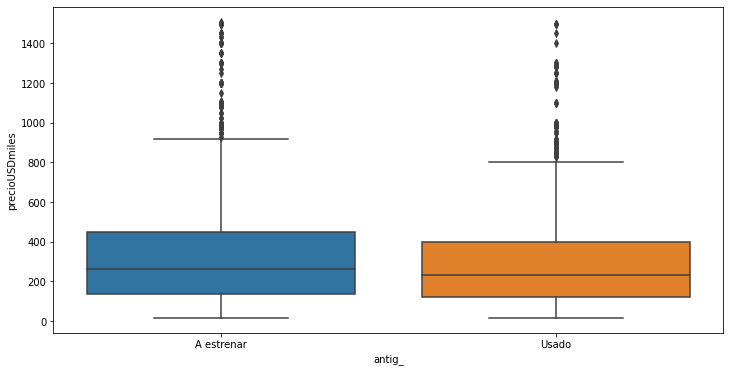

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(x = 'antig_', y= "precioUSDmiles", data = data_grafico)
plt.show()

Podemos ver que el precio de los locales comerciales a estrenar es un poco más elevado que de los locales más antigüos.

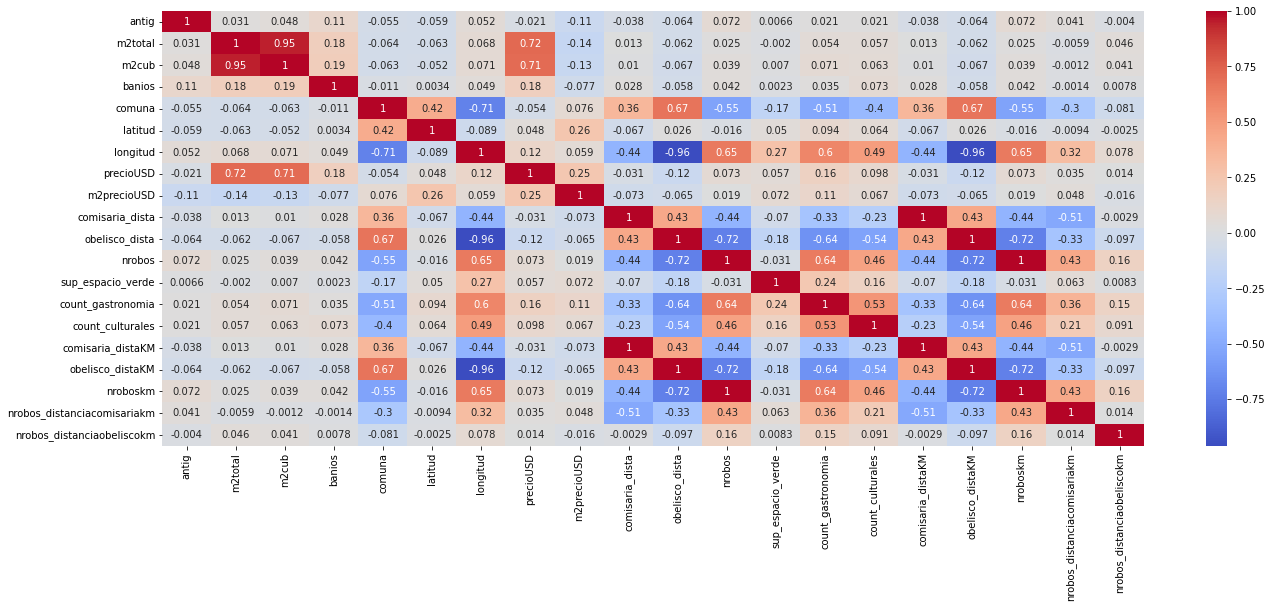

In [ ]:
#Correlación entre las variables.
plt.figure(figsize=(22,8))
corr= data.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap = "coolwarm")

Con el heatmap vamos que las variables que tienen una mayor correlación lineal con la variable objetivo son: los metros cuadrados, tanto totales como cubiertos, también tiene correlación el número de locales gastronómicos cercanos.

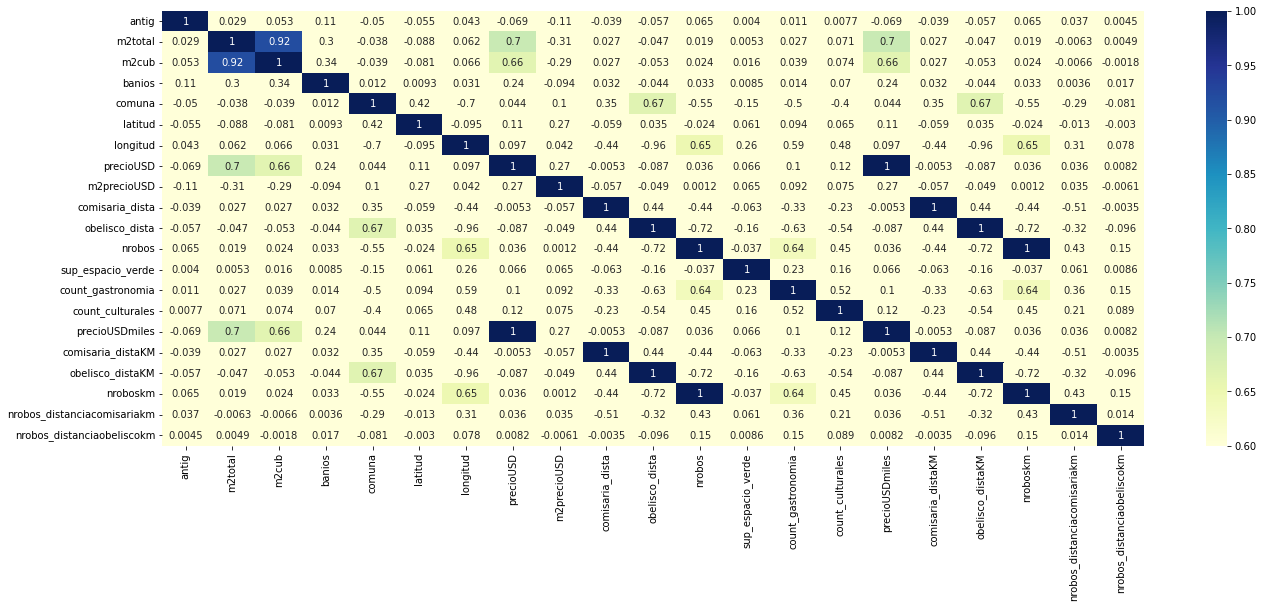

In [ ]:
#Analisis de correlacion sin tener en cuenta los valores extremos de la variable objetivo. 
#HAGO DE NUEVO LA MATRIZ DE CORRELACIÓN, ACOTADA A VARIABLES DE INTERÉS Y LAS NUEVAS
plt.figure(figsize=(22,8))
corr= data_grafico.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap="YlGnBu", vmin=0.60)

In [ ]:
#Grafico de la relacion entre los metros cuadrados totales y el precio de los locales comerciales
fig = px.scatter(
    data_grafico, x='m2total', y='precioUSDmiles', opacity=0.65,
    trendline='ols', trendline_color_override='red',
    marginal_x='box',
    marginal_y='violin', 
    hover_data=['antig', 'comuna'],
    title = 'Relación entre los metros cuadrados totales y el precio de los locales comerciales'
)
fig.update_traces(marker_size=10, marker_color= 'rgba(255, 182, 193, .9)')
fig.show()

Como ya vimos con el heatmap vemos la correlacion positiva que existe entre dos variables, a mayor cantidad de metros cuadrados del local, mayor es el precio. aunque se ven casos particulares donde hay locales más grandes pero con menor precio, debido a factores externos que afectan el precio.

#V. Modelado. Regresión Lineal

**Primera prueba**

In [ ]:
#Creamos un dataframe con las variables que vamos a tener cuenta en el modelo. 
sub_data = data_grafico[['m2total','antig','banios','precioUSDmiles']]

In [ ]:
#Definimos las variables predictoras y la variable de respuesta. 
X = sub_data[['m2total','antig','banios']] 
y = sub_data['precioUSDmiles']        

In [ ]:
#Dividimos en train y en test. Entrenaremos el modelo en el conjunto de entrenamiento y luego usaremos el conjunto de prueba para evaluar el modelo.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1234)

In [ ]:
#Vemos la dimensión de cada dataset
print('X_train: ', X_train.shape)
print('X_test: ',  X_test.shape)
print('y_train: ', y_train.shape)
print('y_test: ', y_test.shape)

X_train:  (2760, 3)
X_test:  (690, 3)
y_train:  (2760,)
y_test:  (690,)


A priori comenzamos con un Regresor Dummy

In [ ]:
## medida del error
def rmse(y1, y2):
    """
    Raiz cuadrada del error cuadrático medio.
    """
    return np.sqrt(mean_squared_error(y1, y2))

In [ ]:
dummyModel = DummyRegressor(strategy='median')
dummyModel.fit(X_train, y_train)
pred_train = dummyModel.predict(X_train)
pred_test = dummyModel.predict(X_test)
print('Train RMSE = {:.0f}'.format(rmse(pred_train, y_train)))
print('Test  RMSE = {:.0f}'.format(rmse(pred_test, y_test)))

Train RMSE = 287
Test  RMSE = 281


**Continuamos con Regresión lineal**

In [ ]:
def cross_val(model):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [ ]:
lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)





LinearRegression(normalize=True)

In [ ]:
#Evaluamos e interpretamos el modelo.
print(lin_reg.intercept_)

118.08825773105818


In [ ]:
coeff_df = pd.DataFrame(lin_reg.coef_, X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
m2total,1.501238
antig,-1.148973
banios,17.612769


Intepretación de los coeficientes:

Manteniendo todas las demás características fijas, un aumento de 1 unidad en metros cuadrados totales está asociado con un aumento del precio de venta de usd 1500,24.
Manteniendo todas las demás características fijas, un aumento de 1 unidad en la antiguedad del local está asociado con una disminución del precio de venta de usd 1174,68
Manteniendo todas las demás características fijas, un aumento de 1 unidad en los baños de los locales está asociado con un aumento del precio de venta de usd 1741,96


In [ ]:
#Veamos predicciones para evaluar el modelo.
pred = lin_reg.predict(X_test)

In [ ]:
test_pred = lin_reg.predict(X_test)
train_pred = lin_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 131.2240688841225
MSE: 40842.84792635969
RMSE: 202.0961353573088
R2 Square 0.4525976605381742
__________________________________
Train set evaluation:
_____________________________________
MAE: 131.95772233345758
MSE: 37542.52168546327
RMSE: 193.75892672458542
R2 Square 0.5062440416368683
__________________________________


In [ ]:
results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test, test_pred) , cross_val(LinearRegression())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,131.224069,40842.847926,202.096135,0.452598,0.480585


El modelo de regresión lineal, arroja un Error medio elevado, lo que implica que el precio predicho dista en gran medida del precio objetivo, es decir, la predicción no es precisa. En cuanto al MSE, el resultado empeora aún mas, por la penalización de valores atípicos. Respecto al coeficiente R2, se obtiene un valor aceptable, pero aún así la lógica del modelo en general, no nos resulta adecuada. Finalmente, respecto al error obtenido en validación cruzada, la media aritmetica de los errores señala casi un 50%, lo cual no es aceptable.

Text(0.5, 1.0, 'Linear Regression Model')

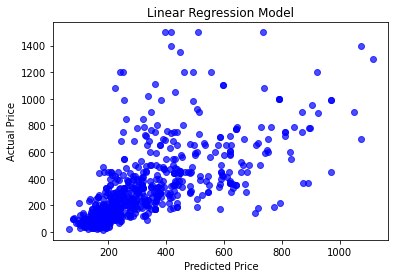

In [ ]:
# make predictions based on model
predictions = lin_reg.predict(X_test)
# alpha helps to show overlapping data
plt.scatter(predictions, y_test, alpha = 0.7, color = 'b')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')

In [ ]:
def residplot(model,X,y,**kwargs):
    '''
    Esta función nos permitirá calcular los errores de estimación
    Inputs:
        model = modelo entrenado
        X: variables predictoras (dataframe) 
        y: vaiable de respuesta (dataframe)
        kwargs: argumentos residuales deseaborn.residplot
    Output:
        diagrama de dispersión: residuos vs. valores predichos 
    '''
    vals = {'Residuos': y-model.predict(X), 'Predicciones': model.predict(X)}  # Agregar residuos estandarizados
    resdf = pd.DataFrame(vals)
    ax = sns.residplot(y='Residuos',x='Predicciones', data=resdf, **kwargs)
    return ax


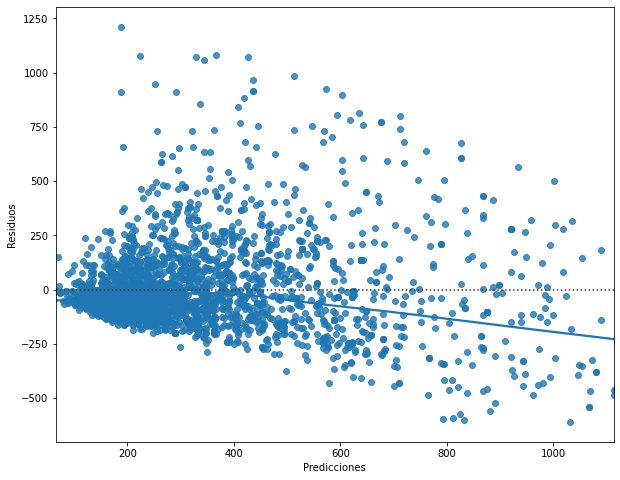

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
residplot(lin_reg, X_train, y_train, lowess = True)
plt.show() #corregir escala en K 

¿Cuáles son las dos principales características que se observan en el plot anterior?

- Forma de $C$.
- La dispersión no es constante (heterocedasticidad): incrementa la dispersión con los valores de las predicciones. Es decir, mientras más predicciones hacemos, más ambigüedad se obtiene.

#V. Modelado. Regresión Polinomial

**Segunda Prueba**

In [ ]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

!pip install plotly==5.3.1                  
import plotly.express as px                 # Librería que permite realizar visualizaciones interactivas 
                                            # Algunas funciones usadas se encuentran en versiones más actuales: desde la  4.12.0
                                            # Si tiene una versión anterior, instalar: !pip install plotly==5.3.1
# Consultar versión de plotly instalada
import plotly
print(plotly.__version__)

5.3.1


In [ ]:
# Seleccionamos las variables a considerar y eliminamos los messing's
sub_data = data_grafico[['m2total','banios','precioUSDmiles',"antig","count_gastronomia", "obelisco_dista", "comisaria_dista", "sup_espacio_verde", "nrobos", "count_culturales"  ]]
sub_data = sub_data.dropna()

# Dividimos el dataset entre variables predictoras
X = sub_data[['m2total','banios',"antig","count_gastronomia", "obelisco_dista", "comisaria_dista", "sup_espacio_verde", "nrobos", "count_culturales" ]]  # Variables predictoras
y = sub_data['precioUSDmiles']  

In [ ]:
#importamos librerias a utilizar
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1234)

In [ ]:
#visualizamos el tamaños de las muestras y test
print('X_train: ', X_train.shape)
print('X_test: ',  X_test.shape)
print('y_train: ', y_train.shape)
print('y_test: ', y_test.shape)

X_train:  (2760, 9)
X_test:  (690, 9)
y_train:  (2760,)
y_test:  (690,)


In [ ]:
from sklearn import linear_model
# Instanciamos una clase LinearRegression
lm = linear_model.LinearRegression()

# Ajustamos el modelo con el train dataset
lm.fit(X_train, y_train)

LinearRegression()

In [ ]:
# nos permite obtener algunas test estadísticos básicos del modelo (summary)
!pip install regressors
from regressors import stats    

In [ ]:
stats.summary(lm, X_train, y_train, X_train.columns)

Residuals:
         Min         1Q    Median        3Q        Max
-1110.632600 -60.414600 35.967800 97.856400 623.002200


Coefficients:
                    Estimate  Std. Error   t value  p value
_intercept        120.235192   21.150352  5.684800 0.000000
m2total             1.490849    0.027791 53.645800 0.000000
banios             16.713604    3.761842  4.442900 0.000009
antig              -1.145542    0.169914 -6.741900 0.000000
count_gastronomia   0.459333    0.111130  4.133300 0.000037
obelisco_dista     -0.002257    0.000791 -2.852800 0.004366
comisaria_dista     0.004541    0.009576  0.474200 0.635418
sup_espacio_verde   0.000116    0.000033  3.504800 0.000464
nrobos             -0.201818    0.044926 -4.492300 0.000007
count_culturales    0.902622    0.341659  2.641900 0.008291
---
R-squared:  0.51843,    Adjusted R-squared:  0.51685
F-statistic: 328.94 on 9 features


In [ ]:
#Calculamos algunas métricas usando el modelo entrenado sobre el conjunto de test y entrenamiento
import numpy as np
from sklearn import metrics
predictions = lm.predict(X_test)  # predicción en el test dataset
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 130.42578901641002
MSE: 40503.310878222466
RMSE: 201.2543437499486


###Análisis de residuos

In [ ]:
#Primero analizaremos la linealidad, ya que es un supuesto básico que estamos considerando
def residplot(model,X,y,**kwargs):
    '''
    Esta función nos permitirá calcular los errores de estimación
    Inputs:
        model = modelo entrenado
        X: variables predictoras (dataframe) 
        y: vaiable de respuesta (dataframe)
        kwargs: argumentos residuales deseaborn.residplot
    Output:
        diagrama de dispersión: residuos vs. valores predichos 
    '''
    vals = {'Residuos': y-model.predict(X), 'Predicciones': model.predict(X)}  # Agregar residuos estandarizados
    resdf = pd.DataFrame(vals)
    ax = sns.residplot(y='Residuos',x='Predicciones', data=resdf, **kwargs)
    return ax

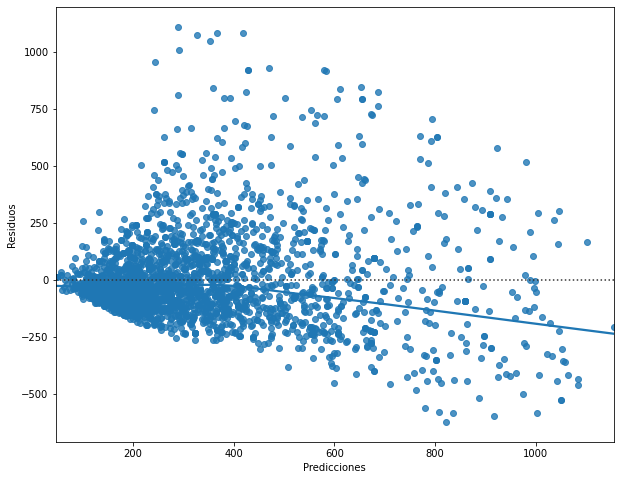

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
residplot(lm, X_train, y_train, lowess = True)
plt.show()

In [ ]:
#La dispersión no es constante (heterocedasticidad): incrementa la dispersión con los valores de las predicciones.
#Estimaremos un modelo polinomial con  M=2 , considerando "todas las variables contra todas".

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

poly_lm = make_pipeline(PolynomialFeatures(2,include_bias=False),
                           LinearRegression())
poly_lm.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('linearregression', LinearRegression())])

In [ ]:
# Guardamos dos elementos (steps) de la salida de de make_pipeline
inpipepf = poly_lm.named_steps['polynomialfeatures']  # variables empleadas en el modelo
inpipelm = poly_lm.named_steps['linearregression']    # modelo entrenado

In [ ]:
inpipepf.n_output_features_  # Consultar cantidad de parámetros estimados

54

In [ ]:
#obtenemos estadisticas del modelo estimado
stats.summary(inpipelm, inpipepf.transform(X_train), y_train, inpipepf.get_feature_names(X.columns))

Residuals:
         Min         1Q    Median        3Q        Max
-1219.302000 -51.137000 23.318100 91.156800 621.700500


Coefficients:
                                      Estimate  Std. Error    t value  p value
_intercept                          214.182041   89.860304   2.383500 0.017216
m2total                               2.010379    0.168411  11.937300 0.000000
banios                               -6.223398   20.679224  -0.300900 0.763476
antig                                -2.886071    0.941776  -3.064500 0.002201
count_gastronomia                     0.177382    0.813073   0.218200 0.827318
obelisco_dista                       -0.010221    0.004743  -2.154900 0.031255
comisaria_dista                      -0.135215    0.057865  -2.336700 0.019524
sup_espacio_verde                     0.001495    0.000176   8.492100 0.000000
nrobos                               -2.406462    0.267113  -9.009100 0.000000
count_culturales                      7.083756    4.543097   1.559200 0.1

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [ ]:
predictions = poly_lm.predict(X_test)

# Si hay predicciones negativas, las igualamos a 0
for i,num in enumerate(predictions):
    if num<0:
        predictions[i] = 0

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('RMSLE:', np.sqrt(metrics.mean_squared_log_error(y_test, predictions)))

MAE: 119.3325774274981
MSE: 35472.21373556828
RMSE: 188.34068529016315
RMSLE: 0.6161293101778621


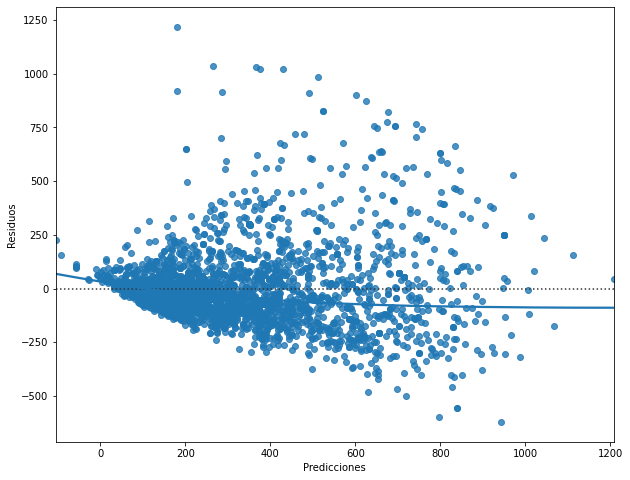

In [ ]:
#residuos del modelo entrenado
fig,ax = plt.subplots()
fig.set_size_inches(10,8)
residplot(inpipelm,inpipepf.transform(X_train), y_train, lowess = True)
plt.show()

In [ ]:
#mejorar la performance del modelo anterior eliminando algunas de los parámetros estimados analizando las métricas de error.
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
RMSLEs = []
Ks = []

for k in range(1,54):
    poly_lm_freg = make_pipeline(PolynomialFeatures(2,include_bias=False), SelectKBest(f_regression,k=k),
                               LinearRegression())
    poly_lm_freg.fit(X_train,y_train)
    predictions = poly_lm_freg.predict(X_test)
    for i,num in enumerate(predictions):
        if num<0:
            predictions[i] = 0
    RMSLEs.append(np.sqrt(metrics.mean_squared_log_error(y_test, predictions)))
    Ks.append(k)

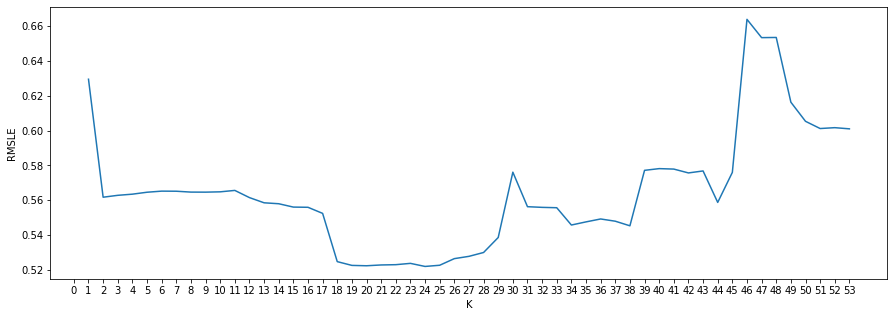

In [ ]:
#graficamos
fig, ax = plt.subplots()
ax.plot(Ks,RMSLEs)
fig.set_size_inches(15,5)
ax.set_xlabel('K')
ax.set_ylabel('RMSLE')
b = ax.set_xticks(range(54))
del b

In [ ]:
#Elegimos el mejor de los modelos
poly_lm_freg = make_pipeline(PolynomialFeatures(2,include_bias=False), SelectKBest(f_regression,k=22),
                               LinearRegression())
poly_lm_freg.fit(X_train,y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('selectkbest',
                 SelectKBest(k=22,
                             score_func=<function f_regression at 0x7f336c387560>)),
                ('linearregression', LinearRegression())])

In [ ]:
predictions = poly_lm_freg.predict(X_test)

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('RMSLE:', np.sqrt(metrics.mean_squared_log_error(y_test, predictions)))

MAE: 121.13182803330038
MSE: 37031.372585557496
RMSE: 192.43537249050004
RMSLE: 0.523017114583531


In [ ]:
inpipepf = poly_lm_freg.named_steps['polynomialfeatures']  # variables empleadas en el modelo
inpipesk = poly_lm_freg.named_steps['selectkbest']         # variables de modelo elegido
inpipelm = poly_lm_freg.named_steps['linearregression']    # modelo entrenado

In [ ]:
from itertools import compress
# La función compress tomar el nombre de las variables con las que efectivamente nos quedamos en el modelo
# inpipesk.get_support(): devuebe True o False de acuerdo a si se queda en el modelo o no
Xlabels = list(compress(inpipepf.get_feature_names(X.columns), inpipesk.get_support()))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [ ]:
stats.summary(inpipelm, inpipesk.transform((inpipepf.transform(X_train))), y_train, Xlabels)

Residuals:
         Min         1Q    Median        3Q        Max
-1192.823700 -46.476200 27.847400 92.867900 604.083200


Coefficients:
                                   Estimate  Std. Error    t value  p value
_intercept                        -2.392146   10.442910  -0.229100 0.818832
m2total                            2.485426    0.117650  21.125600 0.000000
banios                            -2.009831   19.035187  -0.105600 0.915919
count_culturales                   0.155086    0.637995   0.243100 0.807958
m2total^2                         -0.002002    0.000105 -19.100900 0.000000
m2total banios                     0.055504    0.019905   2.788500 0.005332
m2total antig                     -0.004312    0.000836  -5.157300 0.000000
m2total count_gastronomia          0.001636    0.000710   2.302700 0.021371
m2total obelisco_dista            -0.000012    0.000004  -2.833700 0.004635
m2total comisaria_dista           -0.000027    0.000053  -0.505300 0.613417
m2total sup_espacio_verde  

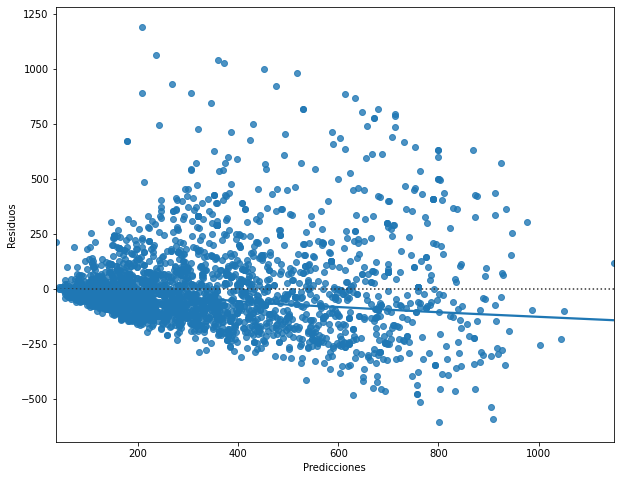

In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(10,8)
residplot(inpipelm,inpipesk.transform((inpipepf.transform(X_train))),y_train, lowess = True)
plt.show()

In [ ]:
#OUTLIERS
def rss(model,X,y):
    '''
    Función para calcular la suma de reiduos al cuadrado
    Input:
        model: modelo de regresión entrenado
        X: Variables predictoras
        y: variable a predecir
    Output:
        Suma de residuos al cuadrado (RSS) del modelo
    '''
    res = y - model.predict(X)
    return sum(res**2)

def rse(model,X,y):
    '''
    Función para calcular el error estándar de los residuos
    Input:
        model: modelo de regresión entrenado
        X: Variables predictoras
        y: variable a predecir
    Output:
        Error estándar de los residuos del modelo (RSE)
    '''
    return np.sqrt(rss(model,X,y)/(X.shape[0]-X.shape[1]-1))

def studresid(model,X,y,threshold=3,ax=None, **kwargs):
    '''
    Función para plotear los residuos estudentizados
    Inputs:
        model = Trained sklearn model
        X: Predictors as a pandas dataframe
        y: Responses as a pandas dataframe
        Threshold: punto de corte para identificar residuos (por defeecto 3)
        kwargs: argumentos adicionales de seaborn.residplot
    Output:
        Un dataframe con: valores predichos, residuos estudentizados y un booleano
        indicando s se trata de un outlier o no 
    '''
    vals = {'Studentized Residuals': (y-model.predict(X))/rse(model,X,y), 'Predicted Values': model.predict(X)}
    resdf = pd.DataFrame(vals)
    resdf['Outlier'] = resdf['Studentized Residuals'].apply(lambda x: 'Outlier' if abs(x)>= threshold else 'Normal')
    return resdf

In [ ]:
#Previous models need to be fitted and ran before running this for correct results
mask_outliers = studresid(inpipelm, inpipesk.transform((inpipepf.transform(X_train))), y_train, ax=ax)

In [ ]:
# Scatter plot
fig = px.scatter(
    mask_outliers, x='Predicted Values', y='Studentized Residuals', color = 'Outlier'
)

fig.add_hrect(y0=-3, y1=3, line_width=0, fillcolor="green", opacity=0.2)

fig.show()

Considerando los residuos estandarizados y sus correspondientes valores predichos, encontramos correlación negativa en valores predichos inferiores a 600 USD, luego la misma se debilita. Es decir, el modelo pierde utilidad para precios altos. En cuanto a los Outliers, su correlación es definitivamente débil pero algo negativa.

#V. Modelado. Árbol de decisión/ Random Forest




Entrenamos Random Forest, modelo basado en árboles de decisión, con el objetivo de mejorar el modelo de regresión lineal

In [ ]:
randomForestRegressor = RandomForestRegressor(random_state=22, n_jobs=-1)
randomForestRegressor.fit(X_train, y_train)
pred_train = randomForestRegressor.predict(X_train)
pred_test = randomForestRegressor.predict(X_test)
print('Train RMSE = {:.0f}'.format(rmse(pred_train, y_train)))
print('Test  RMSE = {:.0f}'.format(rmse(pred_test, y_test)))

Train RMSE = 59
Test  RMSE = 152
